In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mse-2-ai-201-b-aiml-a/sample_submission.csv
/kaggle/input/mse-2-ai-201-b-aiml-a/train.csv
/kaggle/input/mse-2-ai-201-b-aiml-a/test.csv


In [2]:
#importing lib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib

In [4]:
#loading data
train = pd.read_csv("/kaggle/input/mse-2-ai-201-b-aiml-a/train.csv")
test = pd.read_csv("/kaggle/input/mse-2-ai-201-b-aiml-a/test.csv")

display(train.head())
print("\nDATA SHAPE:", train.shape)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,79737.0,1165.818,483.7234,210.5411,80498.0,318.6288,0.9003,0.9905,0.7461,0.7372,2.2975,0.6587,A
1,81893.0,NaN,441.5179,237.5255,83087.0,322.9077,0.8430,NaN,0.7181,0.8098,1.8588,0.7314,B
2,82468.0,NaN,452.2654,232.5943,83212.0,324.0394,0.8576,0.9911,0.6277,0.8045,1.9444,0.7165,B
3,99270.0,1245.963,495.6917,255.7247,100359.0,355.5200,0.8567,0.9891,0.6966,0.8036,1.9384,NaN,A
4,70388.0,1044.665,426.7972,211.0762,71013.0,299.3673,0.8691,0.9912,0.7189,0.8105,2.0220,0.7014,B



DATA SHAPE: (2024, 13)


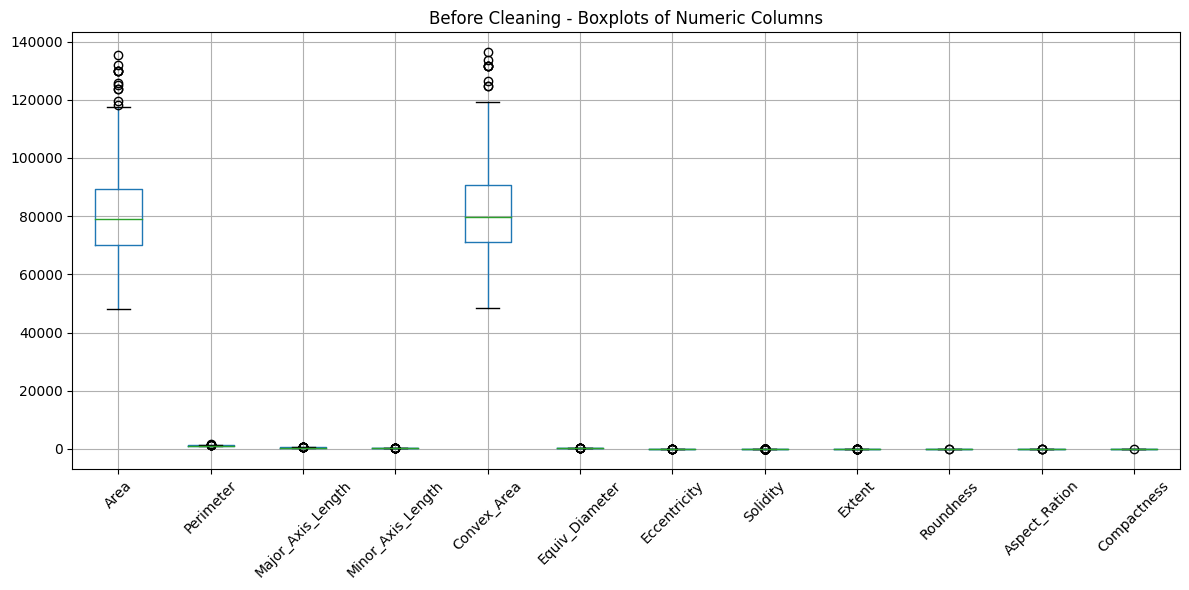


Boxplots for numeric columns (BEFORE imputation).


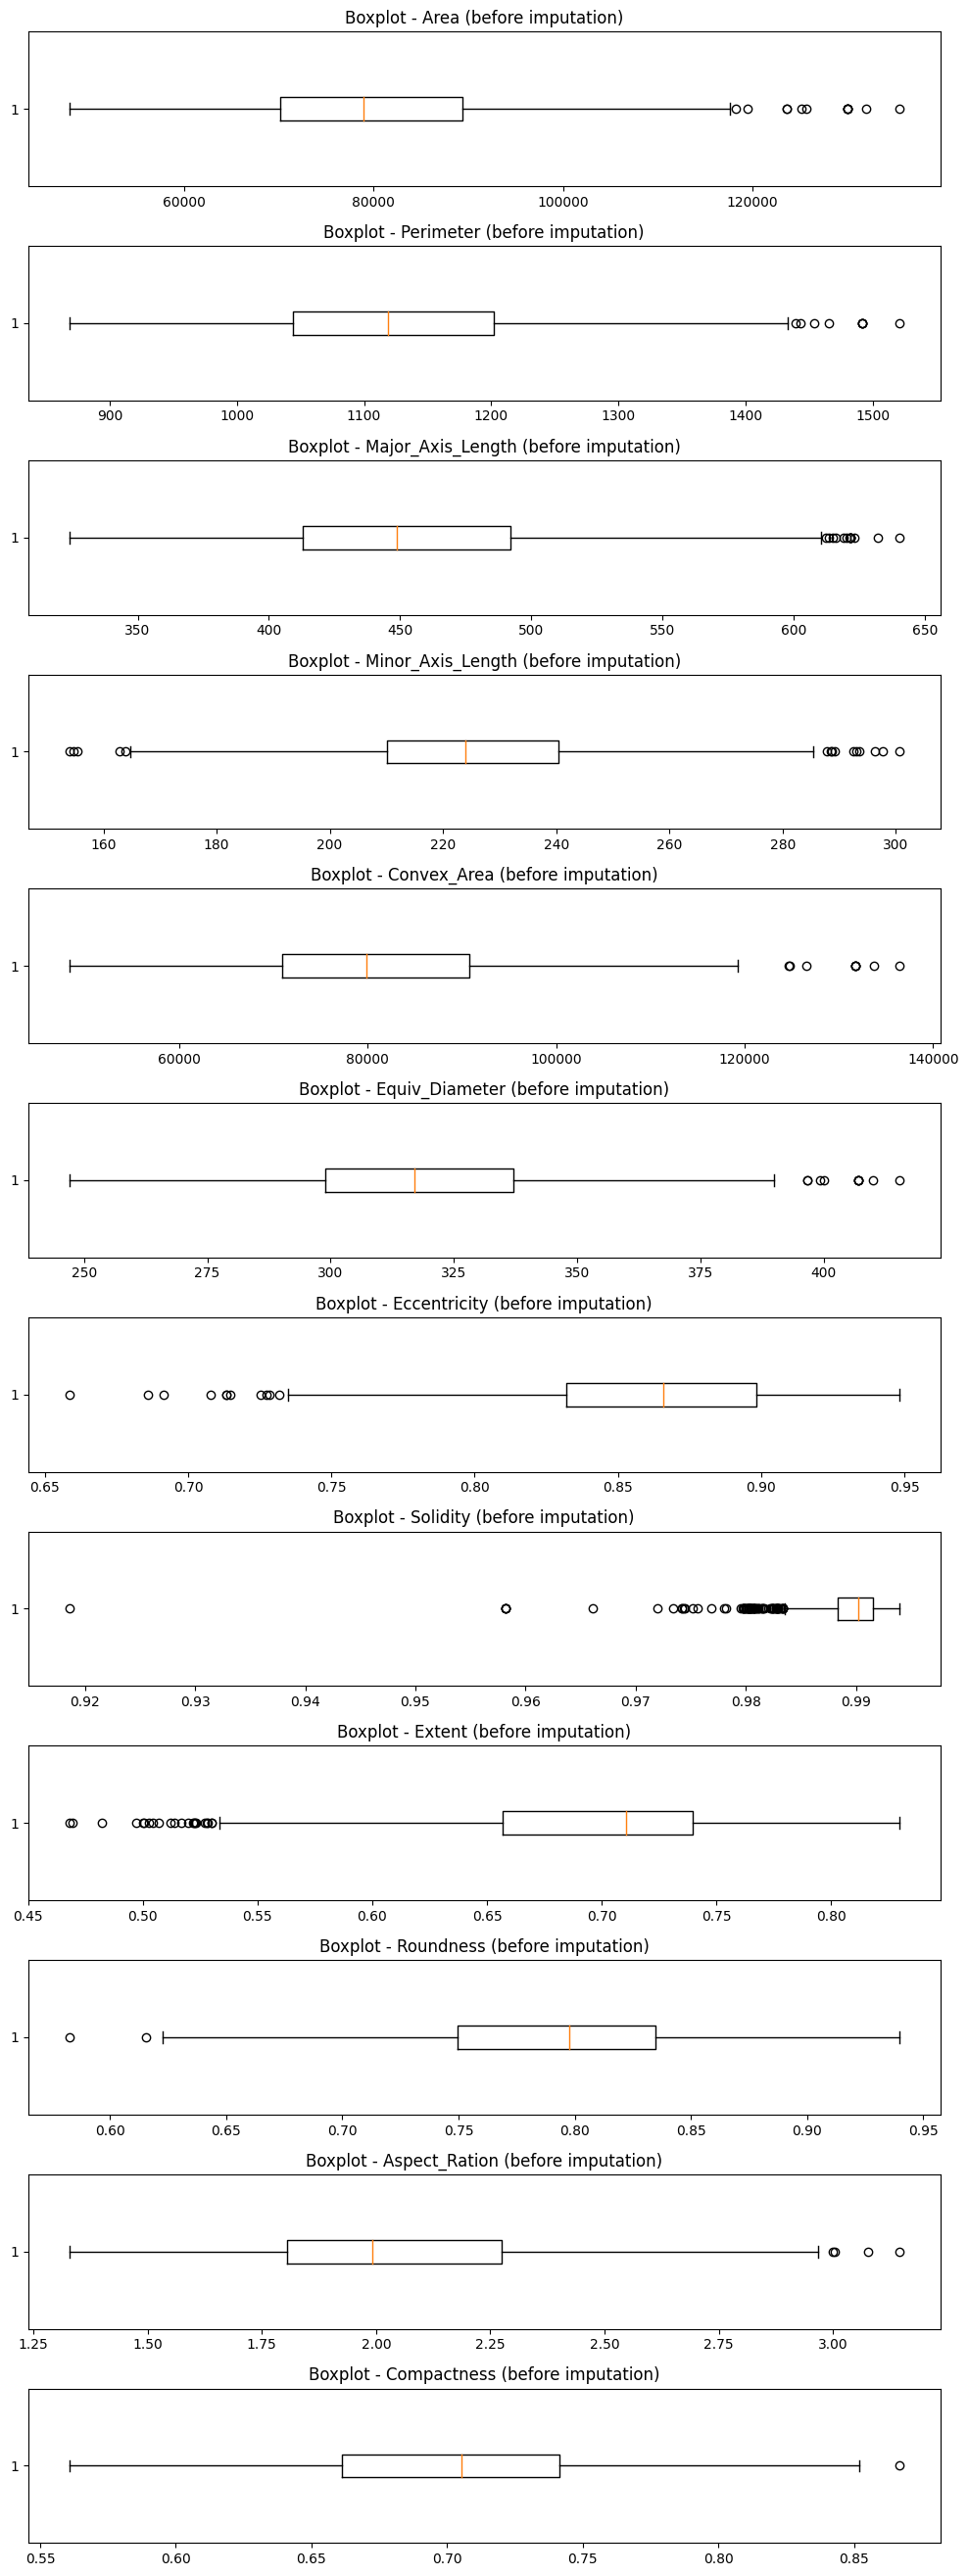

In [7]:
#visualization before cleaning
num_cols = train.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(12, 6))
train[num_cols].boxplot()
plt.title("Before Cleaning - Boxplots of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

num_cols = train.select_dtypes(include=np.number).columns.tolist()
if 'Class' in num_cols:
    num_cols.remove('Class')

print("\nBoxplots for numeric columns (BEFORE imputation).")
plt.figure(figsize=(10, len(num_cols)*2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(train[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col} (before imputation)")
    plt.xlabel("")
plt.tight_layout()
plt.show()

In [8]:
# identifying column types
cat_cols = train.select_dtypes(include=['object','bool']).columns
num_cols = train.select_dtypes(include=['int64','float64']).columns

In [9]:
# fill numeric columns
train[num_cols] = train[num_cols].fillna(train[num_cols].median())

In [10]:
# fill categorical only if they exist
if len(cat_cols) > 0:
    train[cat_cols] = train[cat_cols].fillna(train[cat_cols].mode().iloc[0])

In [11]:
# removing outliers using IQR
clean_df = train.copy()

for col in num_cols:
    Q1 = clean_df[col].quantile(0.25)
    Q3 = clean_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    clean_df = clean_df[(clean_df[col] >= lower) & (clean_df[col] <= upper)]

print("\nNEW SHAPE AFTER OUTLIER REMOVAL:", clean_df.shape)


NEW SHAPE AFTER OUTLIER REMOVAL: (1717, 13)


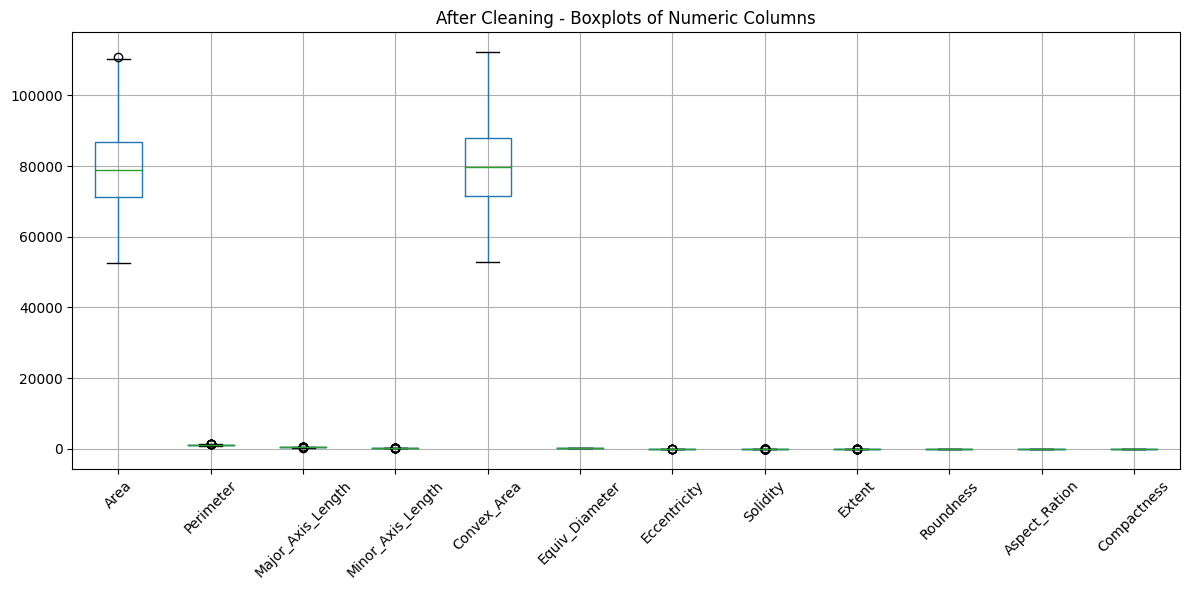


Boxplots for numeric columns (AFTER imputation, BEFORE outlier removal).


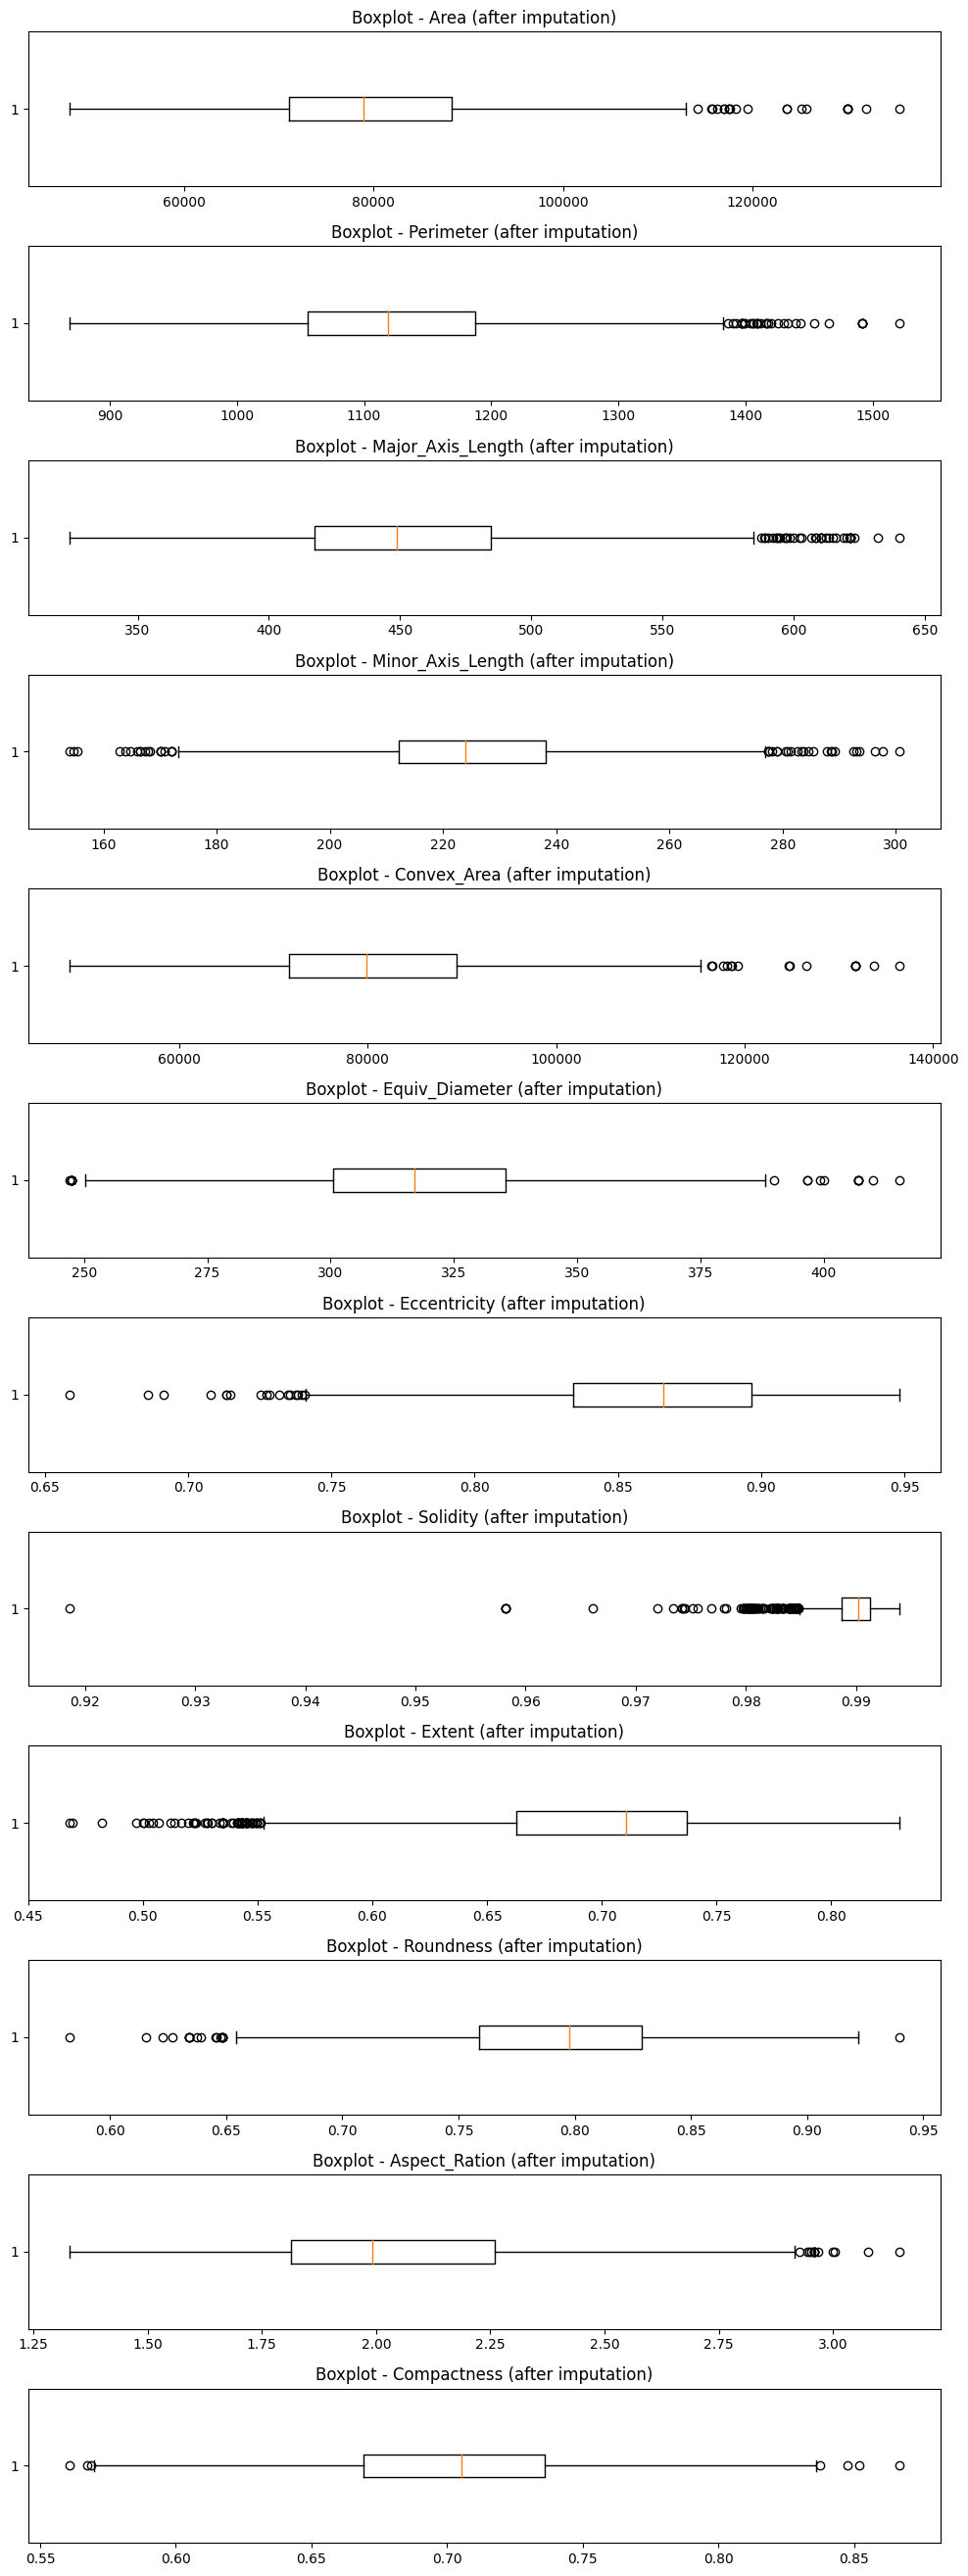

In [12]:
# visualization after cleaning

plt.figure(figsize=(12, 6))
clean_df[num_cols].boxplot()
plt.title("After Cleaning - Boxplots of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nBoxplots for numeric columns (AFTER imputation, BEFORE outlier removal).")
plt.figure(figsize=(10, len(num_cols)*2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(train[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col} (after imputation)")
    plt.xlabel("")
plt.tight_layout()
plt.show()

In [24]:
# train_test_split
X = clean_df.drop("Class", axis=1)
y = clean_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# MODEL 1 — RANDOM FOREST
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

rf_pred = rf.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, rf_pred)

In [32]:
# MODEL 2 — KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

knn_acc = accuracy_score(y_test, knn_pred)


In [36]:
# model comparison
print(f"RF Accuracy: {rf_acc}, {rf_acc*100}")

print(f"KNN Accuracy: {knn_acc}, {knn_acc*100}")

RF Accuracy: 0.8546511627906976, 85.46511627906976
KNN Accuracy: 0.8313953488372093, 83.13953488372093


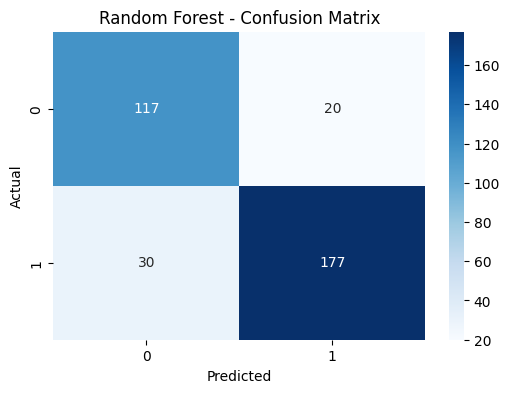

In [37]:
# conf matrix for RF
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
# Save models and scaler
joblib.dump(rf, "rf_model_simple.joblib")
joblib.dump(knn, "knn_model_simple.joblib")
joblib.dump(scaler, "scaler_simple.joblib")

['scaler_simple.joblib']

In [41]:
# submission
test_ids = X_test.index
test_pred = rf_pred

sub = pd.DataFrame({
    'id': test_ids,
    'Class': test_pred
})

sub.to_csv("submission_Ayushmaan70.csv", index=False)
display(sub)
print("Saved: submission_Ayushmaan70.csv, rf_model_simple.joblib, knn_model_simple.joblib, scaler_simple.joblib")

,id,Class
0,703,B
1,1576,B
2,131,A
3,152,A
4,395,A
...,...,...
339,1402,B
340,123,B
341,1183,B
342,2000,B


Saved: submission_Ayushmaan70.csv, rf_model_simple.joblib, knn_model_simple.joblib, scaler_simple.joblib
